# Requirements

In [1]:
# from google.colab import drive
from keras.utils.data_utils import Sequence
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K
import skimage
import numpy as np
import os
import cv2

In [2]:
from numpy.random import seed
import os
import random
import numpy as np
import skimage
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, UpSampling2D, Dense, Cropping2D, Dropout, Concatenate, BatchNormalization
from keras import backend as keras
from keras import losses, metrics
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.backend import flatten
from PIL import Image
from datetime import datetime

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jmeyo6ki because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# drive.mount('/content/drive')

In [4]:
# %cd /content/drive/MyDrive/db/segmentation
# !unzip sartorius.zip

In [5]:
print("Version: ", tf.version.VERSION)

Version:  2.9.1


# Dataset

In [6]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, batch_size, dim, input_img_paths, shuffle=True):
        self.batch_size = batch_size
        self.dim = dim
        self.input_img_paths = input_img_paths
        self.shuffle = shuffle

        self.input_img_paths.sort()
        if self.shuffle:
          random.shuffle(self.input_img_paths)
       

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.input_img_paths) // self.batch_size


    def __getitem__(self, idx):
        'Generate one batch of data'
        i = idx * self.batch_size  

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        X = self._generate_X(batch_input_img_paths)
        y = self._generate_y(batch_input_img_paths)
        
        return X,y

    # Shuffle order in which model recieves data
    def on_epoch_end(self):
        if self.shuffle:
          random.shuffle(self.input_img_paths)


    # Normalizes values of a matrix between 0 and 1
    def myNormalization(self, data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))


    def _load_input_image(self, image_path):
        'Load input image'

        img = cv2.imread(image_path, 0)

        img = cv2.resize(img, (224,224))
        img = self.myNormalization(img)

        return img


    def _load_target_image(self, image_path):
        'Load target image'

        img = cv2.imread(image_path, 0)

        img = cv2.resize(img, (224,224), interpolation=cv2.INTER_NEAREST)
        img = self.myNormalization(img)
        img = np.uint8(img)

        return img


    def _generate_X(self, batch_input_img_paths):
        'Generates data containing batch_size images'
        X = np.empty((self.batch_size, *self.dim))
        
        for i, path in enumerate(batch_input_img_paths):
            X[i,] = np.reshape(self._load_input_image(path), (224,224,1))
            
        return X
    
    def _generate_y(self, batch_input_img_paths):
        'Generates data containing batch_size masks'
        y =  np.empty((self.batch_size, *self.dim))
        
        for i, path in enumerate(batch_input_img_paths):
            y[i,] = np.reshape(self._load_target_image(path.replace('images','masks')), (224,224,1))
            
        return y

# Utils

In [7]:
# From leticia
# def dice_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#   union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
#   dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
#   return dice

# From towards data science

def dice_coef(y_true, y_pred, smooth=1):
    print('dice coef')
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    # print('coef intersection', intersection)
    # print('coef union', union)
    return (2 * intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred):
    # print('dice loss')
    return 1. - dice(y_true, y_pred)


def dice(y_true, y_pred, smooth=1e-4):
    # print('dice')
    #flatten label and prediction tensors
    # print(y_true, y_pred)
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)
    # print('dice gt', targets)
    # print('dice pred', inputs)
    # print(inputs.shape, targets.shape)
    intersection = K.sum(targets * inputs)
    union = K.sum(y_true) + K.sum(y_pred)
    # print('dice intersection', intersection)
    # print('dice union', union)
    dice = (2. * intersection) / (union + smooth)
    # print(dice)
    return dice

def bce_dice_loss(y_true, y_pred):
    print('bce dice loss')
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)
    # print(targets.shape, inputs.shape)
    bce =  losses.binary_crossentropy(targets, inputs)
    dice_bce = bce + dice_loss(y_true, y_pred)
    return dice_bce

def iou(y_true, y_pred, smooth=1.):
    print('iou')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def showHistory(history):
    # list all data in history
    print(history.history.keys())
    fig = plt.figure(figsize=(10,6))

    # summarize history for accuracy
    plt.plot(history.history['dice'])
    plt.plot(history.history['val_dice'])
    plt.title('Model accuracy',fontsize=20)
    plt.ylabel('Dice',fontsize=20)
    plt.xlabel('Epoch',fontsize=20)
    plt.legend(['Train', 'Val'], loc='center right',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)
    plt.ylim([0.0, 1.0])
    plt.show()

    # summarize history for loss
    fig = plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',fontsize=20)
    plt.ylabel('Loss',fontsize=20)
    plt.xlabel('Epoch',fontsize=20)
    plt.legend(['Train', 'Val'], loc='center right',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)
    plt.ylim([0.0, 1.0])
    plt.show()
    

def sanity_check_generator(gen):
    cols = 2
    rows = 5
    graph_row = 0

    f, ax_arr = plt.subplots(rows, cols)
    for idx, data in enumerate(gen):
#         print('Batch {}|{}'.format(idx, gen.__len__()-1))
        
        img, target = data
        
        for j in range(len(img)):
#             print('\tImage {}|{}'.format(j, len(img)-1))
            
            ax_arr[graph_row,0].imshow(img[j])
            ax_arr[graph_row,0].set_axis_off()
            
            ax_arr[graph_row,1].imshow(target[j])
            ax_arr[graph_row,1].set_axis_off()
            
            graph_row += 1

    plt.show()

    
def render_preds(val_gen, preds, worst_list=None):
  
    cols = 3
    rows = 8
    graph_row = 0
    
#     print(len(preds))
    
    f, ax_arr = plt.subplots(rows, cols)
    for idx, data in enumerate(val_gen):

        images, targets = data
        
        for j in range(len(images)):
            
            image = images[j]
            target = targets[j]

#             print('Trying: {}|{} {}'.format(j, len(images), graph_row))

            if worst_list != None:
                for entry in worst_list:
                    if entry[0] == j:
                        print('\tRendering:', entry)
                        ax_arr[graph_row,0].imshow(image)
                        ax_arr[graph_row,1].imshow(target)
                        ax_arr[graph_row,2].imshow(preds[j])
                        
                        ax_arr[graph_row,0].set_axis_off()
                        ax_arr[graph_row,1].set_axis_off()
                        ax_arr[graph_row,2].set_axis_off()
                        
                        graph_row += 1
                        
                        break

                if graph_row == rows-1:
                    break
                        
            else:
                ax_arr[graph_row,0].imshow(image)
                ax_arr[graph_row,1].imshow(target)
                ax_arr[graph_row,2].imshow(preds[j])

                ax_arr[graph_row,0].set_axis_off()
                ax_arr[graph_row,1].set_axis_off()
                ax_arr[graph_row,2].set_axis_off()

                graph_row += 1

                if j == rows-1:
                    break
                
        plt.show()

        break
    
    
def get_timestamp():
    now = datetime.now()

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%Y-%m-%d_%H-%M")
#     print("date and time =", dt_string)
    
    return dt_string

In [8]:
# # metrics sanity check
# gt = tf.constant([[0., 0., 0., 0.],
#                   [0., 1., 1., 0.],
#                   [0., 1., 1., 0.],
#                   [0., 0., 0., 0.]])

# pd = tf.constant([[0., 0., 0., 0.],
#                   [0., 1., 1., 0.],
#                   [0., 1., 1., 0.],
#                   [0., 0., 0., 0.]])

# print('Types:', type(gt), type(pd))
# print('\nValues:', gt, pd)
# print('\nDices: {}\n\t{}'.format(dice(gt, pd), dice_coef(gt, pd)))
# # print('\nBCE Dice: {}'.format(bce_dice_loss(gt, pd)))

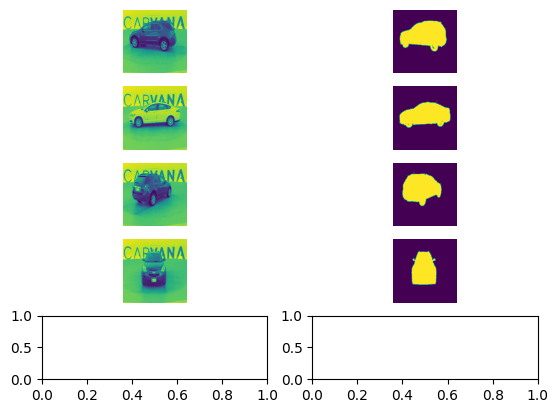

In [9]:
sanity_files = np.load('/home/leite/Workspace/db/segmentation/mockup/names_train.npy')
sanity_generator = DataGenerator(2, (224,224,1), sanity_files)
sanity_check_generator(sanity_generator)

# Model

In [10]:
# # Leticia
# def unet(input_size = (224,224,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     conv1 = BatchNormalization()(conv1)
#     drop1 = Dropout(0.4)(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     conv2 = BatchNormalization()(conv2)
#     drop2 = Dropout(0.4)(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     drop3 = Dropout(0.4)(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     drop4 = Dropout(0.4)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.4)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = concatenate([drop4,up6], axis = 3)
#     drop6 = Dropout(0.4)(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     drop7 = Dropout(0.4)(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     drop8 = Dropout(0.4)(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     drop9 = Dropout(0.4)(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid', name='seg_output')(conv9)

#     model = Model(inputs, conv10)

#     return model

In [11]:
# Giovanna
def unet(input_size = (224,224,1)):
    inputs = Input(shape=input_size)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid', name='seg_output')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    return model

In [12]:
def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x

def unet_plus_plus(input_shape, n_labels):
    dropout_rate = 0.5
    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', padding='same', name='seg_output')(conv1_5)

    model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

In [13]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''

    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid', name='lung_output')

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Training

In [14]:
MODEL_NAME = 'unet' # [unet, unetpp, MultiResUnet]
DB_NAME = 'mini-carvana'
ROOT_DIR = '/home/leite/Workspace/db/segmentation/'
SAVE_ROOT_DIR = '/home/leite/Workspace/runs/'

BATCH_SIZE = 64
VAL_BATCH = 16
EPOCHS = 1000
LEARNING_RATE = 1e-3

TRAIN_PATH = os.path.join(ROOT_DIR, DB_NAME, 'train/images/')
VAL_PATH = os.path.join(ROOT_DIR, DB_NAME, 'val/images/')

print(TRAIN_PATH)
print(VAL_PATH)

/home/leite/Workspace/db/segmentation/mini-carvana/train/images/
/home/leite/Workspace/db/segmentation/mini-carvana/val/images/


In [15]:
# train_file_names = os.listdir(TRAIN_PATH)
# val_file_names = os.listdir(VAL_PATH)

# train_file_names.sort()
# val_file_names.sort()

# train_file_names = [ os.path.join(TRAIN_PATH, f_name) for f_name in train_file_names ]
# val_file_names = [ os.path.join(VAL_PATH, f_name) for f_name in val_file_names ]

# np.save(ROOT_DIR + DB_NAME + '/names_train.npy', train_file_names)
# np.save(ROOT_DIR + DB_NAME + '/names_val.npy', val_file_names)

In [16]:
train_file_names = np.load(os.path.join(ROOT_DIR + DB_NAME, 'names_train.npy'))
val_file_names = np.load(os.path.join(ROOT_DIR + DB_NAME, 'names_val.npy'))

print('Samples:')
print('train[0]:', len(train_file_names), train_file_names[0])
print('val[0]:', len(val_file_names), val_file_names[0])

Samples:
train[0]: 384 /home/leite/Workspace/db/segmentation/mini-carvana/train/images/00087a6bd4dc_05.jpg
val[0]: 32 /home/leite/Workspace/db/segmentation/mini-carvana/val/images/02159e548029_06.jpg


In [17]:
def goTrain():
    image_size = (224,224,1)

    training_generator = DataGenerator(BATCH_SIZE, image_size, train_file_names)
    validation_generator = DataGenerator(VAL_BATCH, image_size, val_file_names, shuffle=False)

    # sanity_check_generator(training_generator)
    # sanity_check_generator(validation_generator)
    # return
  
    custom_early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10,  
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        verbose=1,
        mode="auto",
        min_delta=0.0001,
        cooldown=3,
        min_lr=0,
    )

    model = None

    if MODEL_NAME == 'unet':
        model = unet()
    elif MODEL_NAME == 'unetpp':
        model = unet_plus_plus((224, 224, 1), 1)
    elif MODEL_NAME == 'MultiResUnet':
        model = MultiResUnet(224, 224, 1)
        

    optim = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        beta_1=0.9,
        beta_2=0.99
    )
    model.compile(
        optimizer=optim,
        loss=dice_loss,
        metrics=[dice]
    )
  
    # model.summary()

    # checkpoint
    # filepath="/content/drive/MyDrive/test_unet_keras/checkpoints/unet2D_exec_2022-05-11-EQE+{epoch:02d}.hdf5"
    # checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', 
    #       verbose=1, save_best_only=True, mode='max')
  
  
  # print("data prepared, ready to train!")
  #model.load_weights('/content/drive/MyDrive/Pesquisa-Doc/Colab Notebooks/check-unet-inter/fseg-dados_selecionados-dice/unet2D_exec_2022-04-27-EQE+52.hdf5')
  #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [dice_coef])
  
  # Fit the model
  # history_model = model.fit(training_generator, batch_size=32, epochs=10, validation_data=validation_generator)
    history_model = model.fit(training_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=validation_generator, verbose=2, callbacks=[custom_early_stopping, reduce_lr])
  # print('\n---------------------')
  # history_model = model.fit(generator=training_generator, validation_data=validation_generator, callbacks=[checkpoint, custom_early_stopping], epochs=4000, verbose=2)
  # history_model = model.fit_generator(generator=training_generator, callbacks=[checkpoint, custom_early_stopping], epochs=150, verbose=2)
    return model, history_model, validation_generator, training_generator

# Run

In [18]:
model, model_history, val_gen, train_gen = goTrain()

Epoch 1/1000
6/6 - 12s - loss: 0.7030 - dice: 0.2970 - val_loss: 0.7013 - val_dice: 0.2987 - lr: 0.0010 - 12s/epoch - 2s/step
Epoch 2/1000
6/6 - 5s - loss: 0.6830 - dice: 0.3170 - val_loss: 0.6316 - val_dice: 0.3684 - lr: 0.0010 - 5s/epoch - 848ms/step
Epoch 3/1000
6/6 - 5s - loss: 0.5166 - dice: 0.4834 - val_loss: 0.3024 - val_dice: 0.6976 - lr: 0.0010 - 5s/epoch - 854ms/step
Epoch 4/1000
6/6 - 5s - loss: 0.2922 - dice: 0.7078 - val_loss: 0.2221 - val_dice: 0.7779 - lr: 0.0010 - 5s/epoch - 850ms/step
Epoch 5/1000
6/6 - 5s - loss: 0.2018 - dice: 0.7982 - val_loss: 0.2570 - val_dice: 0.7430 - lr: 0.0010 - 5s/epoch - 835ms/step
Epoch 6/1000
6/6 - 5s - loss: 0.1688 - dice: 0.8312 - val_loss: 0.1407 - val_dice: 0.8593 - lr: 0.0010 - 5s/epoch - 830ms/step
Epoch 7/1000
6/6 - 5s - loss: 0.1271 - dice: 0.8729 - val_loss: 0.1373 - val_dice: 0.8627 - lr: 0.0010 - 5s/epoch - 832ms/step
Epoch 8/1000
6/6 - 5s - loss: 0.1071 - dice: 0.8929 - val_loss: 0.1045 - val_dice: 0.8955 - lr: 0.0010 - 5s/epoc

# Predictions

In [19]:
preds = model.predict(val_gen)

2/2 [==============================] - 1s 203ms/step


In [20]:
def get_worst_preds_idx_list(preds, gen):
    p_idx = 0
    dice_dict = {}
    
    for idx, data in enumerate(gen):
        _, gts = data
        
        for j in range(len(gts)):
            gt = gts[j]
            pred = preds[p_idx].astype('float')
            
#             print(type(gt), gt.dtype, type(pred), pred.dtype)
            dice_dict[p_idx] = float(dice(gt, pred))
            
            p_idx += 1
    
    sorted_dict = sorted(dice_dict.items(), key=lambda item: item[1])
    print(sorted_dict[:8])
    return sorted_dict[:8]

[(23, 0.9233953357892022), (14, 0.9329038376595676), (21, 0.9377341144279701), (1, 0.9413111457662509), (9, 0.942864602190102), (0, 0.9472567884003738), (31, 0.9489653621910065), (7, 0.9508429396143991)]
	Rendering: (0, 0.9472567884003738)
	Rendering: (1, 0.9413111457662509)
	Rendering: (7, 0.9508429396143991)
	Rendering: (9, 0.942864602190102)
	Rendering: (14, 0.9329038376595676)


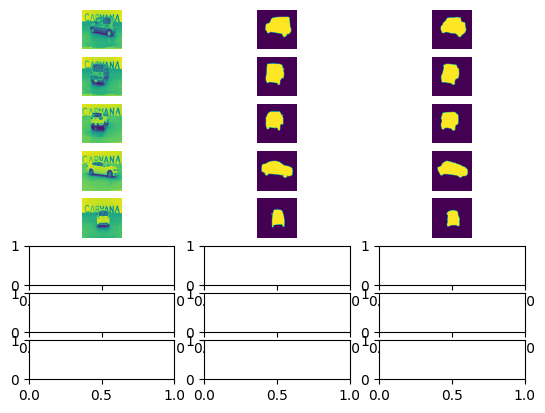

In [21]:
worst_idxs = get_worst_preds_idx_list(preds, val_gen)
render_preds(val_gen, preds, worst_idxs)

# Save

In [22]:
model_folder = os.path.join(SAVE_ROOT_DIR, 'models', MODEL_NAME)
graphs_folder = model_folder.replace('models', 'graphs')

model_file_name = '{}_{}_({})_batch-{}_ep-({}-{})_lr-{}'.format(
    DB_NAME,
    MODEL_NAME,
    get_timestamp(),
    BATCH_SIZE,
    EPOCHS,
    EPOCHS,
    LEARNING_RATE)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    os.makedirs(graphs_folder)

print(os.path.join(model_folder, model_file_name + '.hdf5'))
# model.save(os.path.join(model_folder, model_file_name + '.hdf5'))

/home/leite/Workspace/runs/models/unet/mini-carvana_unet_(2022-07-22_19-19)_batch-64_ep-(1000-1000)_lr-0.001.hdf5


dict_keys(['loss', 'dice', 'val_loss', 'val_dice', 'lr'])


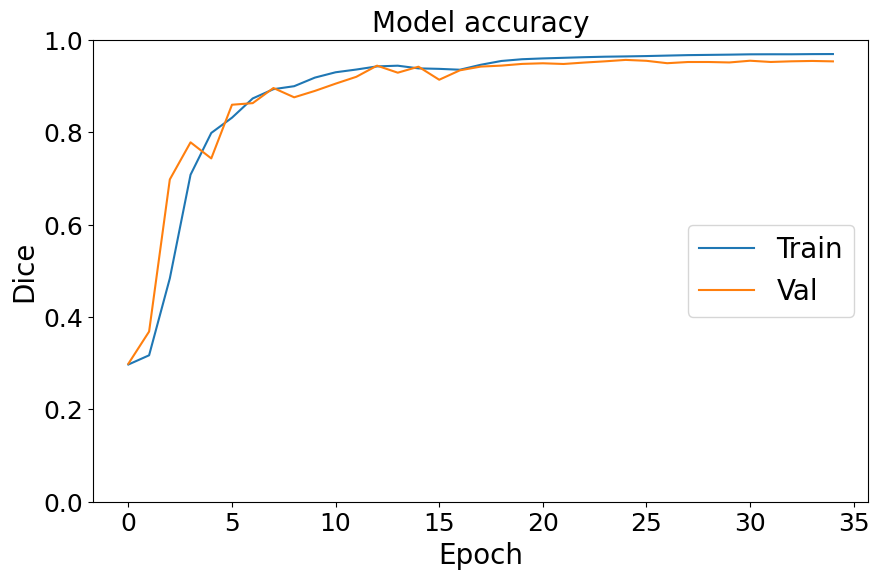

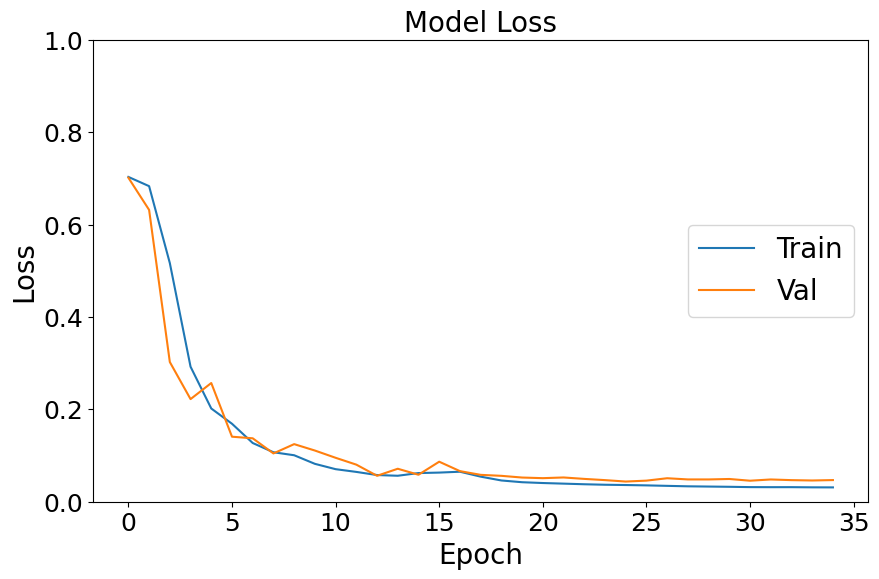

In [23]:
showHistory(model_history)